In [1]:
%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
from nsec.samplers import ScoreHamiltonianMonteCarlo
from nsec.datasets.two_moons import get_two_moons
from nsec.replica_exchange_mc import ReplicaExchangeMC

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import partial

def logp(x, sigma):
    return get_two_moons(sigma+0.02).log_prob(x).squeeze()

dlogp = jax.jit(jax.grad(logp))

In [3]:
def score_fn(x, sigma):
    sigma = sigma.reshape((-1,1))
    @partial(jax.vmap, in_axes=(0,0))
    def inner_fn(x, sigma):
        return dlogp(x[0], sigma[0]).reshape((-1, 2))
    return inner_fn(x, sigma)

In [4]:
logp(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/francois/.local/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


(4,)

In [5]:
score_fn(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

(4, 1, 2)

In [6]:
# def score(x, s):
#     return np.zeros([4,1,2])

In [17]:
sigmas = np.array([0., 0.02, 0.1, 0.5])
step_size = 0.1*np.sqrt(sigmas).reshape((4,1,1))+0.01

In [18]:
sigmas

DeviceArray([0.  , 0.02, 0.1 , 0.5 ], dtype=float32)

In [19]:
step_size

DeviceArray([[[0.01      ]],

             [[0.02414213]],

             [[0.04162278]],

             [[0.08071068]]], dtype=float32)

In [20]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [21]:
remc = ReplicaExchangeMC(
    target_score_fn=score_fn,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=4)

In [22]:
def trace_swaps(unused_state, results):
  return (results.is_swap_proposed_adjacent,
          results.is_swap_accepted_adjacent)

In [23]:
num_results = int(1e4)
num_burnin_steps = int(5e2)

In [24]:
samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [25]:
[len(where(trace[:,i,0])[0]) for i in range(4)]

[9810, 9711, 9922, 9992]

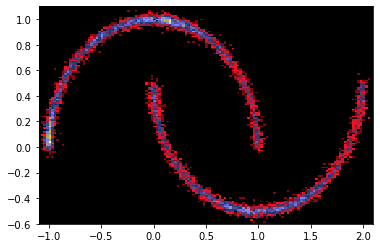

In [26]:
hist2d(samples[:,0,0],samples[:,0,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

In [46]:
from nsec.datasets.swiss_roll import get_swiss_roll

dist = get_swiss_roll(0.1)

In [48]:
rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

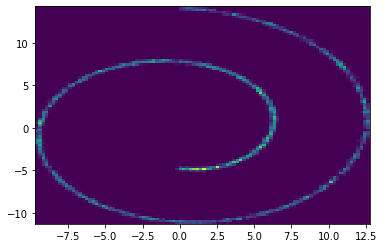

In [49]:
# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);

In [50]:
from functools import partial

def logp(x, sigma):
    return get_swiss_roll(sigma+0.1).log_prob(x).squeeze()

dlogp = jax.jit(jax.grad(logp))

In [51]:
def score_fn(x, sigma):
    sigma = sigma.reshape((-1,1))
    @partial(jax.vmap, in_axes=(0,0))
    def inner_fn(x, sigma):
        return dlogp(x[0], sigma[0]).reshape((-1, 2))
    return inner_fn(x, sigma)

In [113]:
sigmas = np.array([0., 0.05, 0.1, 0.5, 1, 3.])
step_size = 0.5*np.sqrt(sigmas).reshape((6,1,1))+0.1

In [128]:
num_results = int(1e4)
num_burnin_steps = int(5e2)

In [129]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [134]:
remc = ReplicaExchangeMC(
    target_score_fn=score_fn,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=4)

In [135]:
samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

In [136]:
[len(where(trace[:,i,0])[0]) for i in range(6)]

[8331, 7116, 7847, 9142, 9463, 9785]

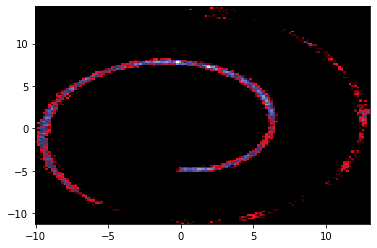

In [137]:
hist2d(samples[:,0,0],samples[:,0,1],128,cmap='gist_stern');

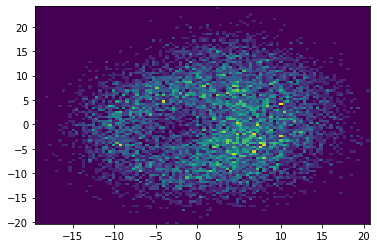

In [96]:

dist = get_swiss_roll(0.1+3)

rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);

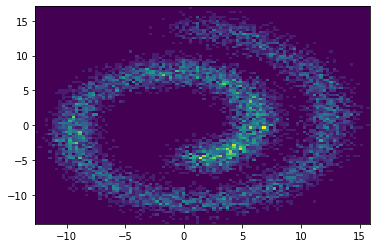

In [97]:

dist = get_swiss_roll(0.1+1)

rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);

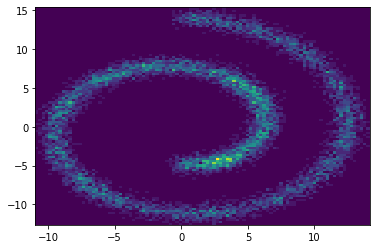

In [98]:

dist = get_swiss_roll(0.1+0.5)

rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);

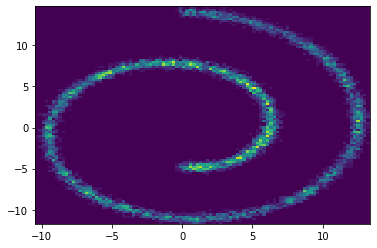

In [99]:

dist = get_swiss_roll(0.1+0.2)

rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);

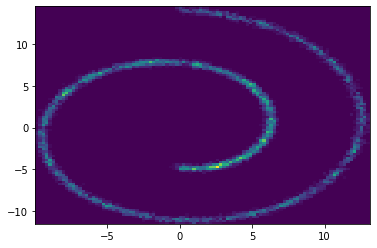

In [100]:

dist = get_swiss_roll(0.1+0.1)

rng_key = jax.random.PRNGKey(seed=0)
samps1 = dist.sample(10000, seed=rng_key)

# This is the target distribution
hist2d(samps1[:,0], samps1[:,1],100);